In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

# Data Prep

In [2]:
path = "../../DataTrimmed/"
dfs = {}

In [3]:
def prepare_df(df):
    df.rename(columns={'Geo_NAME': 'zip_code'}, inplace=True)
    df = df.loc[pd.to_numeric(df.zip_code).between(10000,20000)] # Filtering rows to limit the data we work on. Selecting group of states starting with 1
    df.set_index('zip_code', inplace=True)
    table_names = ['SE_B13004', 'SE_B18002', 'SE_A03001', 'SE_A13007', 'SE_A14028','SE_A14024_', 'SE_B12001', 'SE_A12003', 'SE_A12004', 'SE_A17005', 'SE_A17009', 'SE_A20001', 'SE_A00002','SE_A10036','SE_A18009']
    matching_columns = [col for col in df.columns if col.startswith(tuple(table_names))]
    df = df.loc[:, df.columns.isin(matching_columns)]
    df = df.astype(float)
    df = df.dropna() # Drop rows with missing values

    return df


In [4]:
def process_columns(df):
    df['underPoverty'] = np.where(df[('SE_B13004_005')].div(df[('SE_B13004_001')]) < 0.5,1,0) 
    df = df.loc[: ,~df.columns.str.startswith('SE_B13004')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A13007_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'incomeBelowPovertyLevelProportion'] = ((df.loc[:,('SE_A13007_002')].values) /(df.loc[:,('SE_A13007_001')].values))
    df.incomeBelowPovertyLevelProportion.describe()
    df = df.loc[: ,~df.columns.str.startswith('SE_A13007')] # Drop the columns from the table after processing

    df.loc[:, 'incomePerCapita'] = df.loc[: ,df.columns.str.startswith('SE_A14024_001')].values
    df = df.loc[: ,~df.columns.str.startswith('SE_A14024')] # Drop the columns from the table after processing

    df.loc[:, 'incomeGiniIndex'] = df.loc[: ,df.columns.str.startswith('SE_A14028_001')] 
    df = df.loc[: ,~df.columns.str.startswith('SE_A14028')] # Drop the columns from the table after processing

    df.loc[:, 'popDensity'] = df.loc[:,('SE_A00002_002')].values 
    df = df.loc[: ,~df.columns.str.startswith('SE_A00002')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A03001_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'whiteMajority'] = ((df.loc[:,'SE_A03001_002'].values) / (df.loc[:,'SE_A03001_001'].values)) # If the proportion of white alone population is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A03001')] # Drop the columns from the table after processing

    df = df.loc[df['SE_B12001_001'] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'eduHsOrLessProportion'] = ((df.loc[:,('SE_B12001_002')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df.loc[:, 'eduHsProportion'] = ((df.loc[:,('SE_B12001_003')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df.loc[:, 'eduBachOrBetterProportion'] = ((df.loc[:,('SE_B12001_004')].values) / (df.loc[:,('SE_B12001_001')].values)) # Proportion of 25yo and over with less than high school education
    df = df.loc[: ,~df.columns.str.startswith('SE_B12001_')] # Drop the columns from the table after processing

    df.loc[:, 'eduEnrollmentProportion'] = ((df.loc[:,('SE_A12004_002')].values) / (df.loc[:,('SE_A12004_001')].values)) # If the proportion of 3yo and over enrolled in school is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A12004')] # Drop the columns from the table after processing

    df = df.loc[df['SE_A12003_001'] != 0] # Some of the zip codes have 0 civilian population. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'eduDropoutProportion'] = ((df.loc[:,('SE_A12003_002')].values) / (df.loc[:,('SE_A12003_001')].values)) # If the proportion of late teens dropped out from school is more than 50% we set this binary variable to 1
    df = df.loc[: ,~df.columns.str.startswith('SE_A12003')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A17005_001')] != 0] # Some of the zip codes have 0 civilian population. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'employedProportion'] = ((df.loc[:,('SE_A17005_002')].values) / (df.loc[:,('SE_A17005_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A17005')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A17009_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'employedPvtSecProportion'] = ((df.loc[:,('SE_A17009_002')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedPubSecProportion'] = ((df.loc[:,('SE_A17009_003')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedSelfEmpProportion'] = ((df.loc[:,('SE_A17009_004')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedPvtNonProProportion'] = ((df.loc[:,('SE_A17009_005')].values) / (df.loc[:,('SE_A17009_001')].values))
    df.loc[:, 'employedUnpaidFamProportion'] = ((df.loc[:,('SE_A17009_006')].values) / (df.loc[:,('SE_A17009_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A17009')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:,('SE_A20001_001')] != 0] # Some of the zip codes have 0. To avoid RuntimeWarning we drop these rows
    df.loc[:, 'insuredProportion'] = ((df.loc[:,('SE_A20001_003')].values) / (df.loc[:,('SE_A20001_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A20001')] # Drop the columns from the table after processing

    df = df.loc[df.loc[:, ('SE_B18002_001')] != 0] # Remove observations with 0 to avoid error while dividing
    df.loc[:, 'housingRentMoreThan30pcProportion'] = ((df.loc[:,('SE_B18002_002')].values + df.loc[:,('SE_B18002_003')].values ) / (df.loc[:,('SE_B18002_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_B18002')] # Drop the columns from the table after processing

    df.loc[:, 'housingMedianValue'] = ((df.loc[:,('SE_A10036_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A10036_')] # Drop the columns from the table after processing

    df.loc[:, 'housingMedianGrossRent'] = ((df.loc[:,('SE_A18009_001')].values))
    df = df.loc[: ,~df.columns.str.startswith('SE_A18009')] # Drop the columns from the table after processing

    return df



    

In [5]:
%%time
print("Working on data.............")
for year in range(2017,2022):
    print(f"Processing {year}")
    df_name = f'df{year}'
    filepath = path + str(year) + '_trimmed.csv'
    dfs[df_name] = pd.read_csv(filepath)
    print(f"Preparing df{year} for processing")
    dfs[df_name] = prepare_df(dfs[df_name])
    print(f"Processing df{year} columns")
    dfs[df_name] = process_columns(dfs[df_name])

Working on data.............
Processing 2017
Preparing df2017 for processing
Processing df2017 columns
Processing 2018
Preparing df2018 for processing
Processing df2018 columns
Processing 2019
Preparing df2019 for processing
Processing df2019 columns
Processing 2020
Preparing df2020 for processing
Processing df2020 columns
Processing 2021
Preparing df2021 for processing
Processing df2021 columns
CPU times: total: 35.8 s
Wall time: 45.6 s


# EDA

# Clustering

### KMeans

Beginning df2021 clustering
Scaling df2017 columns
KMeans clustering on df2017
Beginning df2021 clustering
Scaling df2018 columns
KMeans clustering on df2018
Beginning df2021 clustering
Scaling df2019 columns
KMeans clustering on df2019
Beginning df2021 clustering
Scaling df2020 columns
KMeans clustering on df2020
Beginning df2021 clustering
Scaling df2021 columns
KMeans clustering on df2021
CPU times: total: 2min 43s
Wall time: 33.1 s


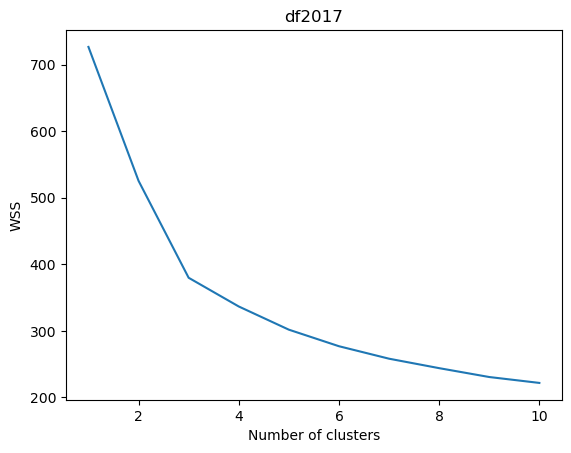

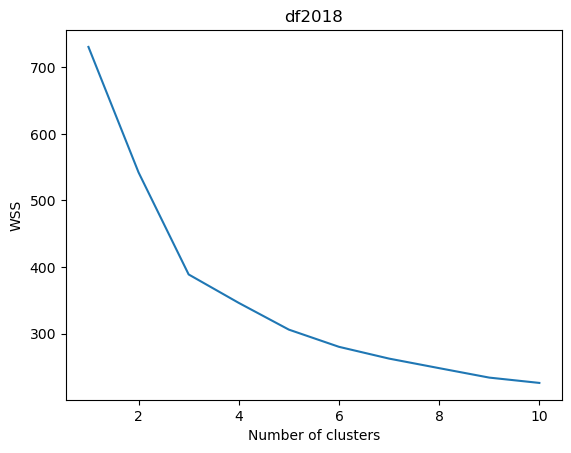

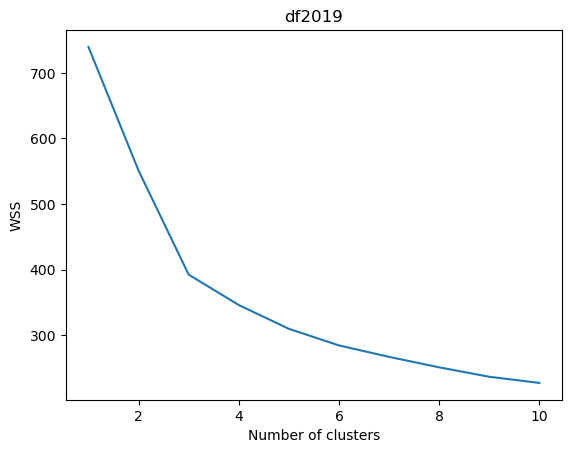

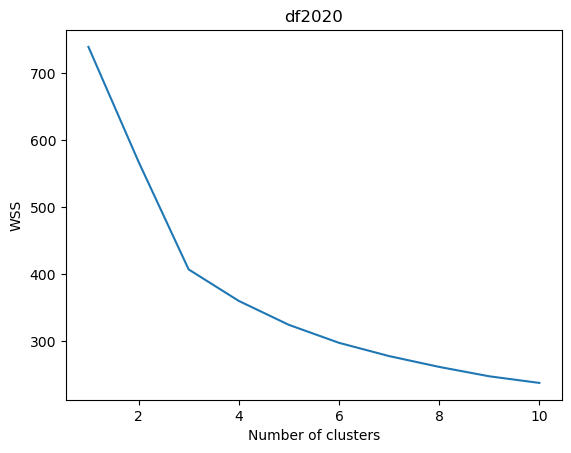

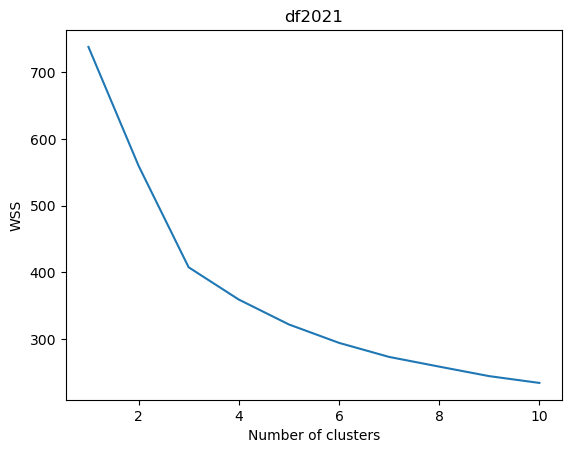

In [6]:
%%time
for key, df in dfs.items():
    print(f"Beginning df{year} clustering")
    wss_df = []
    scaler = MinMaxScaler()
    print(f"Scaling {key} columns")
    scaler.fit(df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']])
    df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']] = scaler.transform(df[['popDensity', 'incomePerCapita','housingMedianValue','housingMedianGrossRent']])
    print(f"KMeans clustering on {key}")
    for i in range(1,11):
        KM = KMeans(n_clusters=i)
        KM.fit(df)
        wss_df.append(KM.inertia_)
    plt.figure()
    plt.title(key)
    plt.xlabel("Number of clusters")
    plt.ylabel("WSS")
    plt.plot(range(1,11), wss_df)

### Silhouette score

In [7]:
%%time
for key, df in dfs.items():
    k_means = KMeans(n_clusters = 2)
    k_means.fit(df)
    labels = k_means.labels_
    df["Clus_kmeans"] = labels
    print(f"silhouette_score for {key}", round(silhouette_score(df,labels),3))

silhouette_score for df2017 0.667
silhouette_score for df2018 0.662
silhouette_score for df2019 0.658
silhouette_score for df2020 0.648
silhouette_score for df2021 0.587
CPU times: total: 16.5 s
Wall time: 4.14 s


### Mean values of the two clusters

In [8]:
%%time
for key, df in dfs.items():
    kmeans_data=df.groupby('Clus_kmeans').mean()
    kmeans_data['Freq']=df.Clus_kmeans.value_counts().sort_index()
    display(key, kmeans_data)

'df2017'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,Freq
Clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.273372,0.094146,0.468907,0.092567,0.589829,0.212302,0.626389,0.161309,0.274009,...,0.687311,0.126071,0.071641,0.112821,0.002155,0.883546,0.507903,0.072042,0.173797,181
1,0.0,0.099324,0.189962,0.416399,0.020795,0.886117,0.101001,0.625267,0.273732,0.223476,...,0.652812,0.145611,0.098252,0.101214,0.002111,0.931310,0.402221,0.100260,0.222421,2706


'df2018'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,Freq
Clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.271247,0.103515,0.470212,0.082221,0.604366,0.207319,0.636368,0.156313,0.273524,...,0.693374,0.118852,0.073078,0.113356,0.001340,0.89715,0.496339,0.064771,0.165990,170
1,0.0,0.098312,0.207157,0.417317,0.022629,0.882209,0.098352,0.621789,0.279859,0.220938,...,0.652662,0.145072,0.098483,0.101507,0.002276,0.94049,0.398693,0.102034,0.217785,2712


'df2019'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,Freq
Clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.264409,0.101535,0.470584,0.085975,0.611257,0.204993,0.635218,0.159790,0.277818,...,0.690552,0.122288,0.074235,0.111116,0.001810,0.907297,0.495828,0.071530,0.163586,171
1,0.0,0.095851,0.207369,0.417920,0.022992,0.880210,0.095682,0.618405,0.285913,0.218086,...,0.650772,0.146314,0.097535,0.103086,0.002292,0.945344,0.393905,0.104994,0.216776,2685


'df2020'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,Freq
Clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.093918,0.180780,0.417489,0.023284,0.866852,0.092936,0.613133,0.293932,0.215336,...,0.644383,0.149133,0.098268,0.105942,0.002274,0.945876,0.385806,0.117230,0.246764,2656
1,1.0,0.266582,0.087622,0.469317,0.082241,0.589462,0.196276,0.633366,0.170358,0.275514,...,0.669233,0.132546,0.074650,0.120093,0.003478,0.911378,0.474961,0.080058,0.188215,155


'df2021'

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,Freq
Clus_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.101138,0.106002,0.262298,0.458207,0.087486,0.644807,0.094493,0.442008,0.463500,0.251684,...,0.628313,0.146065,0.103600,0.120416,0.001606,0.953543,0.474814,0.234297,0.391495,791
1,0.031456,0.101085,0.156428,0.407319,0.003682,0.921182,0.096985,0.678314,0.224701,0.205750,...,0.649127,0.150466,0.093765,0.104077,0.002566,0.940280,0.358334,0.073726,0.154443,1971


CPU times: total: 62.5 ms
Wall time: 180 ms


In [9]:
dfs['df2021']

,underPoverty,incomeBelowPovertyLevelProportion,incomePerCapita,incomeGiniIndex,popDensity,whiteMajority,eduHsOrLessProportion,eduHsProportion,eduBachOrBetterProportion,eduEnrollmentProportion,...,employedPvtSecProportion,employedPubSecProportion,employedSelfEmpProportion,employedPvtNonProProportion,employedUnpaidFamProportion,insuredProportion,housingRentMoreThan30pcProportion,housingMedianValue,housingMedianGrossRent,Clus_kmeans
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,0,0.122854,0.508061,0.5524,0.285369,0.629051,0.072220,0.196375,0.731405,0.166287,...,0.726459,0.060124,0.133758,0.079658,0.000000,0.970333,0.388259,0.230051,0.605381,0
10002,0,0.247883,0.185064,0.5922,0.616638,0.321416,0.322255,0.313974,0.363771,0.172863,...,0.699130,0.102674,0.111372,0.082401,0.004423,0.944278,0.505625,0.356533,0.213965,0
10003,0,0.113830,0.578844,0.5532,0.628712,0.706761,0.036181,0.140121,0.823698,0.283022,...,0.684703,0.054752,0.130395,0.127244,0.002906,0.969856,0.412086,0.483869,0.672325,0
10004,0,0.029659,0.814405,0.4566,0.069479,0.575182,0.003587,0.030905,0.965508,0.131993,...,0.658673,0.079415,0.196823,0.053877,0.011211,0.989364,0.322658,0.860603,1.000000,0
10005,0,0.039515,0.706542,0.3579,0.782497,0.752113,0.000879,0.072339,0.926783,0.101182,...,0.815560,0.068808,0.058244,0.057388,0.000000,0.990390,0.348382,0.617035,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,0,0.076859,0.380454,0.5314,0.005189,0.873479,0.037551,0.444506,0.517943,0.084714,...,0.555074,0.131681,0.189311,0.123935,0.000000,0.974973,0.639066,0.213618,0.323511,0
19973,0,0.148420,0.143945,0.4386,0.002008,0.655685,0.138117,0.683015,0.178868,0.215841,...,0.658000,0.129845,0.122694,0.084992,0.004469,0.927310,0.501057,0.101257,0.172646,1
19975,0,0.068004,0.238288,0.4447,0.002479,0.912903,0.088996,0.535339,0.375665,0.128656,...,0.647491,0.169400,0.105263,0.075887,0.001958,0.924971,0.507911,0.173870,0.238309,1
